# **Testing Deep Learning Architectures for Seismic Event Classification**

### **Author**: Akash Kharita  
### **Last Updated**: October 7, 2024  

---

## **Purpose**
This notebook implements and evaluates various deep learning architectures for classifying seismic events. The dataset includes different seismic sources such as:
- Earthquakes
- Explosions
- Surface events
- Noise

The notebook performs the following tasks:
1. Prepares waveform and spectrogram data from seismic datasets.
2. Trains multiple deep learning models, including custom 1D and 2D convolutional neural networks (CNNs) and residual CNNs.
3. Evaluates the models using metrics such as loss, accuracy, confusion matrices, and classification reports.

---

## **Contents**
1. [Setup and Imports](#Setup-and-Imports)
2. [Metadata Loading](#Metadata-Loading)
3. [Filtered by Signal-to-Noise Ratio (SNR)](#Filtered-by-Signal-to-Noise-Ratio-(SNR))
4. [Extracting Waveform Data](#Extracting-Waveform-Data)
5. [Preparing Input Data (1D and 2D)](#Preparing-Input-Data)
6. [Creating Dataloaders](#Creating-Dataloaders)
7. [Model Training and Evaluation](#Model-Training-and-Evaluation)
    - [SeismicCNN 1D](#SeismicCNN-1D)
    - [SeismicCNN 2D](#SeismicCNN-2D)
    - [QuakeXNet 1D](#QuakeXNet-1D)
    - [QuakeXNet 2D](#QuakeXNet-2D)
    - [QuakeXNet 1D on 2D](#QuakeXNet-1D-on-2D)
    - [BasicResNet 1D](#BasicResNet-1D)
    - [BasicResNet 2D](#BasicResNet-2D)



## Setup and Imports
This section imports all necessary libraries and modules. It also sets up the environment, including:
- Adding custom scripts to the Python path.
- Checking if a GPU is available for training.

Key libraries used:
- **PyTorch**: For building and training neural networks.
- **ObsPy**: For handling seismic data.
- **NumPy and Pandas**: For data processing.
- **Matplotlib**: For plotting and visualizing results.

In [4]:
%reload_ext autoreload
%autoreload 2

In [6]:
# Enable autoreload
%load_ext autoreload
%autoreload 2

import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import obspy
# from tqdm import tqdm
from glob import glob
# import time
import random
import sys
from datetime import datetime
from tqdm import tqdm

from scipy import stats,signal


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset


import numpy as np
import scipy.signal as signal



# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


# Get the current working directory
notebook_dir = os.getcwd()

# Add the ../src directory to the Python path
src_path = os.path.abspath(os.path.join(notebook_dir, 'scripts'))
sys.path.insert(0, src_path)

from neural_network_architectures import QuakeXNet_1d
from neural_network_architectures import QuakeXNet_2d
from neural_network_architectures import QuakeXNet_1d_on_2d

from neural_network_architectures import SeismicCNN_1d
from neural_network_architectures import SeismicCNN_2d

from neural_network_architectures import BasicResNet_1d
from neural_network_architectures import BasicResNet_2d


from helper_functions import extract_waveforms
from helper_functions import extract_spectrograms
from helper_functions import return_train_test_val_loaders
from helper_functions import train_model
from helper_functions import plot_confusion_matrix_and_cr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda
cuda


## Metadata loading
Loads metadata for seismic event classes from CSV files:
- `comcat_metadata`: Metadata for earthquake and explosion events.
- `exotic_metadata`: Metadata for surface events.
- `noise_metadata`: Metadata for noise samples.

Metadata is filtered to create separate dataframes for:
- Earthquakes
- Explosions
- Surface events
- Noise

In [7]:
#data files
file_noise="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_waveforms.hdf5";
file_comcat=  "/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_waveforms.hdf5";
file_exotic="/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_waveforms.hdf5";

# metadata
# accessing the comcat metadata
comcat_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/comcat_metadata.csv")
# comcat_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")

# accessing the exotic metadata
exotic_metadata = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/exotic_metadata.csv")
# exotic_metadata = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")

# accessing the data files
metadata_noise = pd.read_csv("/1-fnp/cascadia/c-whd01/yiyu_data/PNWML/noise_metadata.csv")
# metadata_noise = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")

# creating individual data frames for each class
cat_exp = comcat_metadata[comcat_metadata['source_type'] == 'explosion']
cat_eq = comcat_metadata[comcat_metadata['source_type'] == 'earthquake']
cat_su = exotic_metadata[exotic_metadata['source_type'] == 'surface event']
cat_noise = metadata_noise
cat_noise['event_id'] = [cat_noise['trace_start_time'][i]+'_noise' for i in range(len(cat_noise))]


## Filtered by Signal-to-Noise Ratio (SNR)
Applies a threshold-based filter to exclude low-SNR events:
- SNR threshold (`SNR_THR`) is set to 1 for explosions and earthquakes.
- A slightly lower threshold is used for surface events.

Filtered metadata ensures higher-quality waveforms are used for training.

In [8]:
## defining the threshold
SNR_THR = 1

# explosions
trace_snr_db_values = np.array([float(cat_exp.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_exp.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_exp = cat_exp.iloc[ii2]

# earthquake
trace_snr_db_values = np.array([float(cat_eq.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_eq.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR)[0].astype(int) 
df_eq = cat_eq.iloc[ii2]

# surface events
trace_snr_db_values = np.array([float(cat_su.loc[idx, 'trace_snr_db'].split("|")[-1]) for idx in cat_su.index.values.tolist()])
ii2= np.where(trace_snr_db_values>SNR_THR-2)[0].astype(int) 
df_su = cat_su.iloc[ii2]

# noise
# does not change
df_noise = cat_noise

## Extracting Waveform Data
Waveforms are extracted from `.hdf5` files using the `extract_waveforms` function. Key parameters:
- **Number of channels**: 3 (e.g., Z, N, E components)
- **Sampling rate**: 50 Hz
- **Window length**: 100 samples
- **Bandpass filter**: 1–20 Hz

Each event class (earthquakes, explosions, surface events, noise) is balanced to contain an equal number of samples.


In [9]:
num_channels = 3
number_data_per_class = 8434 ## This is equal to the total number of the samples in the minority class.

# new sampling rate
fs = 50

nos = 2000

# if we are taking all data or not. 
all_data = False

# the start point will be selected randomly from (start, -4)
start = -20
shifting = True

# training parameters
train_split = 70                                      
val_split=20
test_split = 10
learning_rate=0.001
batch_size=128
n_epochs=60
dropout=0.4
criterion=nn.CrossEntropyLoss()

## filtering parameters
highcut = 20
lowcut = 1
input_window_length = 100


# surface events
d_su, id_su = extract_waveforms(df_su, file_exotic, input_window_length = input_window_length, fs=fs,
                                start =start, number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_su.shape)

# noise
d_noise, id_noise = extract_waveforms(df_noise, file_noise, input_window_length = input_window_length, fs=fs,
                                      start = start, number_data = number_data_per_class,
                                      num_channels = num_channels, shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_noise.shape)



# explosions
d_exp, id_exp = extract_waveforms(df_exp, file_comcat, input_window_length = input_window_length, fs=fs,
                                  start = start,  number_data = number_data_per_class, num_channels = num_channels,
                                  shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)

print(d_exp.shape)



# earthquakes
d_eq, id_eq = extract_waveforms(df_eq, file_comcat, input_window_length = input_window_length,  fs=fs,
                                start =start,  number_data = number_data_per_class, num_channels = num_channels,
                                shifting = shifting, all_data = all_data, lowcut = lowcut , highcut =highcut)
print(d_eq.shape)


  0%|          | 11/8434 [00:00<01:19, 106.28it/s]

(3712, 3, 5000)


  0%|          | 8/8434 [00:00<01:56, 72.23it/s]

(5961, 3, 5000)


  0%|          | 0/8434 [00:00<?, ?it/s]

(6175, 3, 5000)


100%|██████████| 8434/8434 [01:57<00:00, 71.96it/s]


(5633, 3, 5000)


## Preparing Input Data
1. **1D Input**:
    - Waveforms are concatenated to create a 1D input dataset (`X_1d`).
2. **2D Input**:
    - Spectrograms are generated using the `extract_spectrograms` function.
    - These are concatenated to create a 2D input dataset (`X_2d`).


In [10]:
# concatenate all data into one input
X_1d = np.vstack([d_eq[0:nos], d_exp[0:nos], d_noise[0:nos], d_su[0:nos]])


# Creating 2D input
s_su = extract_spectrograms(waveforms = d_su[0:nos])
s_noise = extract_spectrograms(waveforms = d_noise[0:nos])
s_eq = extract_spectrograms(waveforms = d_eq[0:nos])
s_exp = extract_spectrograms(waveforms = d_exp[0:nos])

# concatenate all data into one input
X_2d = np.vstack([s_eq, s_exp, s_noise, s_su])

y = [0]*len(d_eq[0:nos])+[1]*len(d_exp[0:nos])+[2]*len(d_noise[0:nos])+[3]*len(d_su[0:nos])

  7%|▋         | 131/2000 [00:00<00:01, 1306.04it/s]

(2000, 3, 129, 38)


  6%|▌         | 122/2000 [00:00<00:01, 1210.51it/s]

(2000, 3, 129, 38)


  6%|▌         | 121/2000 [00:00<00:01, 1206.44it/s]

(2000, 3, 129, 38)


100%|██████████| 2000/2000 [00:01<00:00, 1202.88it/s]


(2000, 3, 129, 38)


## Creating Dataloaders
Dataloaders are prepared for both 1D and 2D inputs using the `return_train_test_val_loaders` function. The dataset is split into:
- **Training set**: 70%
- **Validation set**: 20%
- **Test set**: 10%

Batch size is set to 128.

In [11]:
## Preparing the data loaders for 1d and 2d inputs
train_loader_1d, val_loader_1d, test_loader_1d = return_train_test_val_loaders(X = X_1d, y = y, train_split = train_split, test_split = test_split, val_split = val_split, batch_size = batch_size)
train_loader_2d, val_loader_2d, test_loader_2d = return_train_test_val_loaders(X = X_2d, y = y, train_split = train_split, test_split = test_split, val_split = val_split, batch_size = batch_size)

43 12 6
43 12 6


## Model Training and Evaluation
Trains and evaluates various models using the `train_model` function. Metrics include:
- Training and validation loss
- Validation and test accuracy
- Confusion matrices and classification reports

### **7.1 SeismicCNN 1D**
- Architecture: 1D CNN
- Input: `X_1d`
- Results:
  - Plots training/validation loss and accuracy over epochs.
  - Displays confusion matrix and classification report.

### **7.2 SeismicCNN 2D**
- Architecture: 2D CNN
- Input: `X_2d`
- Results:
  - Similar to SeismicCNN 1D but processes spectrogram inputs.

### **7.3 QuakeXNet 1D**
- Architecture: Custom 1D CNN
- Input: `X_1d`
- Results:
  - Training/validation loss and accuracy plots.
  - Confusion matrix and classification report.

### **7.4 QuakeXNet 2D**
- Architecture: Custom 2D CNN
- Input: `X_2d`
- Results:
  - Similar to MyCNN 1D but processes spectrogram inputs.

### **7.5 QuakeXNet 1D on 2D**
- Architecture: Custom 1D CNN applied to spectrograms.
- Input: `X_2d`
- Results:
  - Evaluates how well a 1D CNN can process spectrogram data.

### **7.6 BasicResNet 1D**
- Architecture: Residual 1D CNN
- Input: `X_1d`
- Results:
  - Demonstrates the power of residual connections in 1D architectures.

### **7.7 BasicResNet 2D**
- Architecture: Residual 2D CNN
- Input: `X_2d`
- Results:
  - Evaluates the performance of a 2D residual architecture on spectrogram inputs.
  

## **Visualization**
Each model training process includes:
- Loss and accuracy plots.
- Confusion matrices to show classification performance.


## SeismicCNN 1D

In [12]:
model_seismiccnn_1d = SeismicCNN_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d,test_loss_seismiccnn_1d,test_accuracy_seismiccnn_1d) = train_model(model_seismiccnn_1d,
    train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:09<00:45,  1.11it/s]

[Epoch 10] loss: 0.279 - accuracy: 50.521


 33%|███▎      | 20/60 [00:19<00:37,  1.07it/s]

[Epoch 20] loss: 0.140 - accuracy: 71.159


 50%|█████     | 30/60 [00:28<00:28,  1.06it/s]

[Epoch 30] loss: 0.087 - accuracy: 74.805


 67%|██████▋   | 40/60 [00:37<00:18,  1.06it/s]

[Epoch 40] loss: 0.058 - accuracy: 77.409


 83%|████████▎ | 50/60 [00:48<00:09,  1.00it/s]

[Epoch 50] loss: 0.043 - accuracy: 80.664


100%|██████████| 60/60 [00:57<00:00,  1.04it/s]

[Epoch 60] loss: 0.032 - accuracy: 79.232
test loss: 0.698 and accuracy: 79.297



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

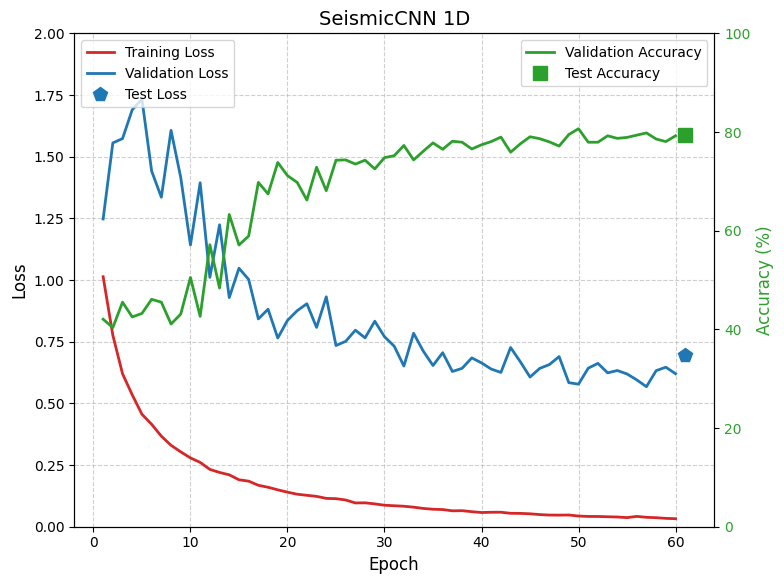

In [13]:
def plot_model_training(loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy, title = 'SeismicCNN 1D'):


    # Assuming loss_time, val_loss_time, val_accuracy_time, test_loss, test_accuracy are defined

    NN = np.count_nonzero(loss_time)
    fig, ax1 = plt.subplots(figsize=(8, 6))  # Increase figure size for better readability

    # Set font sizes
    plt.style.use('default')
    plt.rc('font', size=12)  # Global font size
    plt.rc('axes', titlesize=14)  # Title font size
    plt.rc('axes', labelsize=12)  # Axis label font size
    plt.rc('xtick', labelsize=10)  # X-axis tick label font size
    plt.rc('ytick', labelsize=10)  # Y-axis tick label font size

    # Plot Training and Validation Loss
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.plot(np.arange(1, NN+1), loss_time[:NN], color='tab:red', label='Training Loss', linewidth=2)
    ax1.plot(np.arange(1, NN+1), val_loss_time[:NN], color='tab:blue', label='Validation Loss', linewidth=2)
    ax1.plot(NN+1, test_loss, 'p', color='tab:blue', label='Test Loss', markersize=10)
    ax1.set_ylim(0, 2)
    ax1.grid(True, linestyle='--', alpha=0.6)  # Add grid with some transparency

    # Twin axis for accuracy
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy (%)', fontsize=12, color='tab:green')
    ax2.plot(np.arange(1, NN+1), val_accuracy_time[:NN], color='tab:green', label='Validation Accuracy', linewidth=2)
    ax2.plot(NN+1, test_accuracy, 's', color='tab:green', label='Test Accuracy', markersize=10)
    ax2.set_ylim(0, 100)
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax2.grid(False)

    # Title and legend
    plt.title(title, fontsize=14)
    fig.tight_layout()

    # Add legends for both axes
    ax1.legend(loc='upper left', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)

    # Save the figure with high resolution
    plt.savefig(f"../figures/{title}", dpi=300, bbox_inches='tight')

    plt.show()

plot_model_training(loss_time_seismiccnn_1d, val_loss_time_seismiccnn_1d, val_accuracy_time_seismiccnn_1d, test_loss_seismiccnn_1d, test_accuracy_seismiccnn_1d)

test loss: 0.730 and accuracy: 78.646


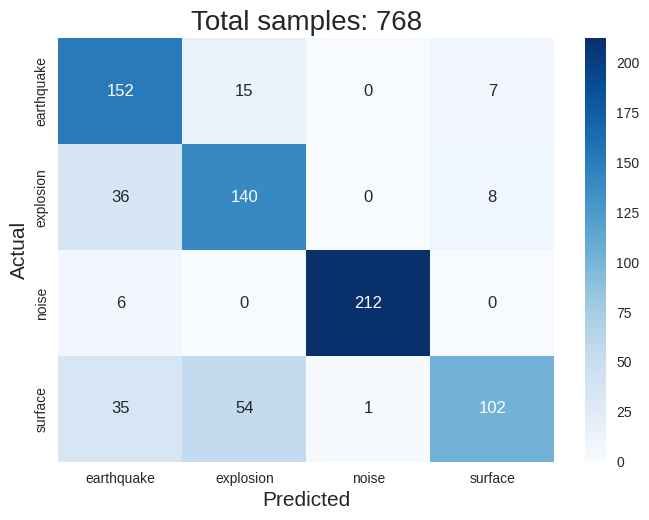

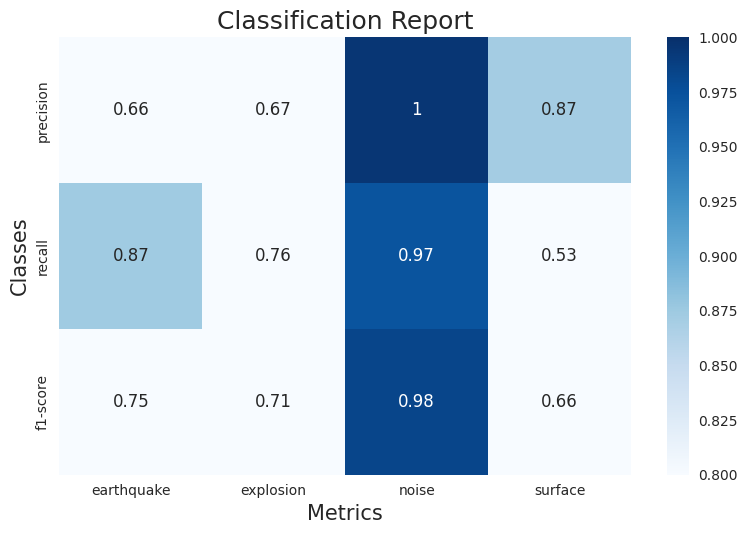

In [14]:
_,_ = plot_confusion_matrix_and_cr(model_seismiccnn_1d, test_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## SeismicCNN 2D

In [26]:
model_seismiccnn_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d,test_loss_seismiccnn_2d,test_accuracy_seismiccnn_2d) = train_model(model_seismiccnn_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_' )

 17%|█▋        | 10/60 [00:07<00:34,  1.46it/s]

[Epoch 10] loss: 0.435 - accuracy: 78.516


 33%|███▎      | 20/60 [00:14<00:27,  1.45it/s]

[Epoch 20] loss: 0.311 - accuracy: 84.245


 50%|█████     | 30/60 [00:20<00:19,  1.53it/s]

[Epoch 30] loss: 0.240 - accuracy: 83.919


 67%|██████▋   | 40/60 [00:27<00:14,  1.39it/s]

[Epoch 40] loss: 0.185 - accuracy: 85.091


 83%|████████▎ | 50/60 [00:34<00:06,  1.47it/s]

[Epoch 50] loss: 0.147 - accuracy: 85.742


100%|██████████| 60/60 [00:41<00:00,  1.46it/s]

[Epoch 60] loss: 0.118 - accuracy: 86.263
test loss: 0.383 and accuracy: 87.240



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

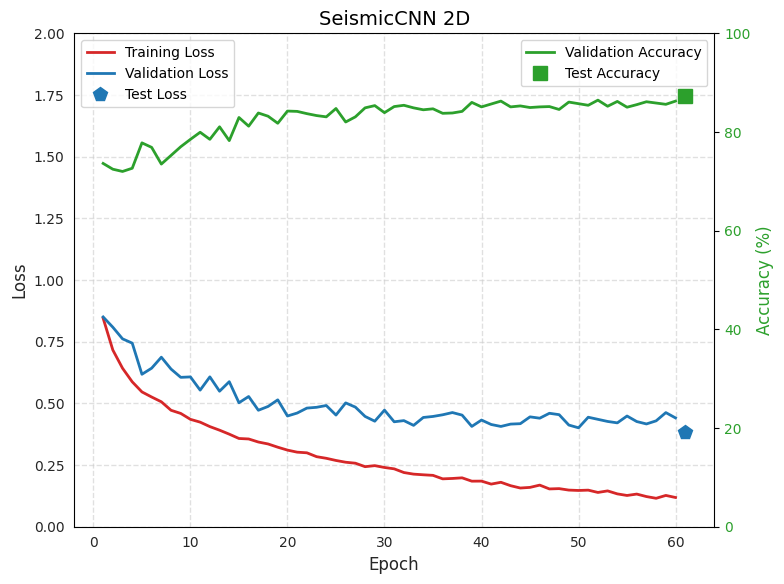

In [27]:
plot_model_training(loss_time_seismiccnn_2d, val_loss_time_seismiccnn_2d, val_accuracy_time_seismiccnn_2d, test_loss_seismiccnn_2d, test_accuracy_seismiccnn_2d, title = 'SeismicCNN 2D')

test loss: 0.378 and accuracy: 87.500


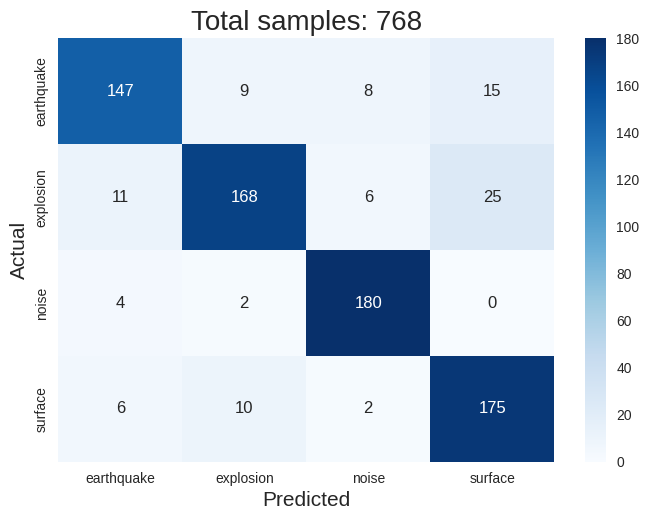

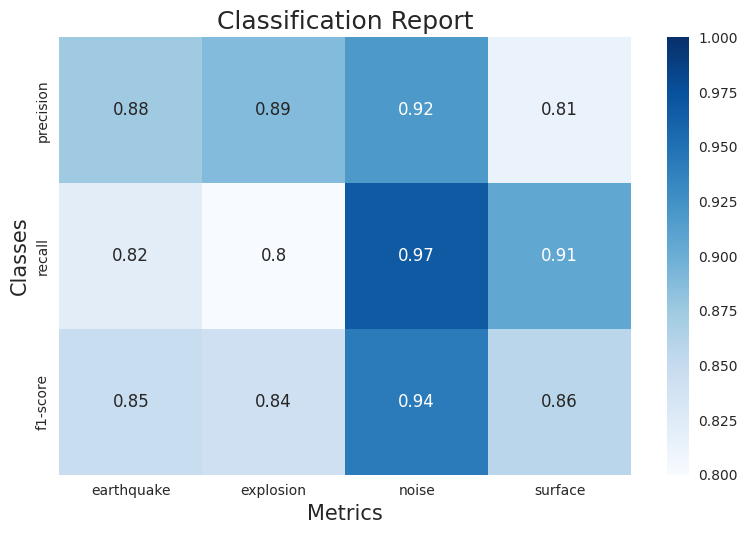

In [28]:
model_seismiccnn_2d.eval()
_,_ = plot_confusion_matrix_and_cr(model_seismiccnn_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## QuakeXNet 1D

In [16]:
model_quakexnet_1d = QuakeXNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_1d, val_loss_time_mycnn_1d, val_accuracy_time_mycnn_1d,test_loss_mycnn_1d,test_accuracy_mycnn_1d) = train_model(model_quakexnet_1d,
    train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:07<00:41,  1.22it/s]

[Epoch 10] loss: 0.417 - accuracy: 76.107


 33%|███▎      | 20/60 [00:15<00:30,  1.31it/s]

[Epoch 20] loss: 0.296 - accuracy: 87.174


 50%|█████     | 30/60 [00:22<00:21,  1.41it/s]

[Epoch 30] loss: 0.232 - accuracy: 89.648


 67%|██████▋   | 40/60 [00:30<00:17,  1.12it/s]

[Epoch 40] loss: 0.192 - accuracy: 88.216


 83%|████████▎ | 50/60 [00:38<00:07,  1.30it/s]

[Epoch 50] loss: 0.161 - accuracy: 89.583


100%|██████████| 60/60 [00:46<00:00,  1.30it/s]

[Epoch 60] loss: 0.128 - accuracy: 89.258
test loss: 0.384 and accuracy: 87.760


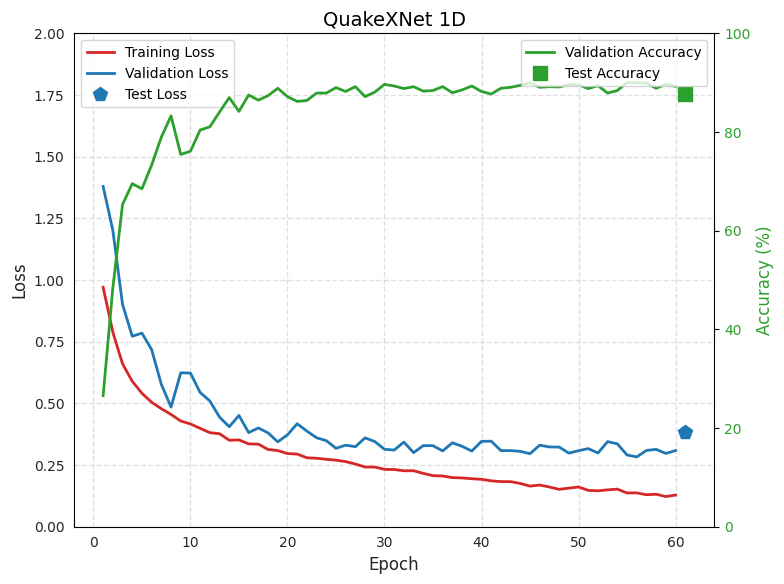

In [17]:
plot_model_training(loss_time_mycnn_1d, val_loss_time_mycnn_1d, val_accuracy_time_mycnn_1d, test_loss_mycnn_1d, test_accuracy_mycnn_1d, title = 'QuakeXNet 1D')

test loss: 0.394 and accuracy: 87.630


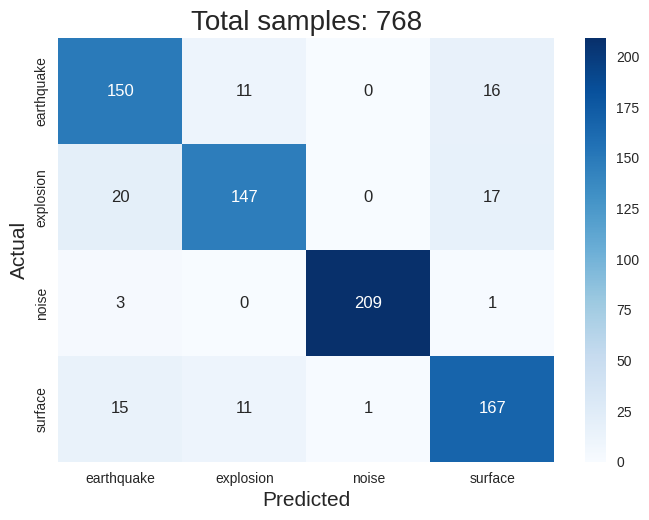

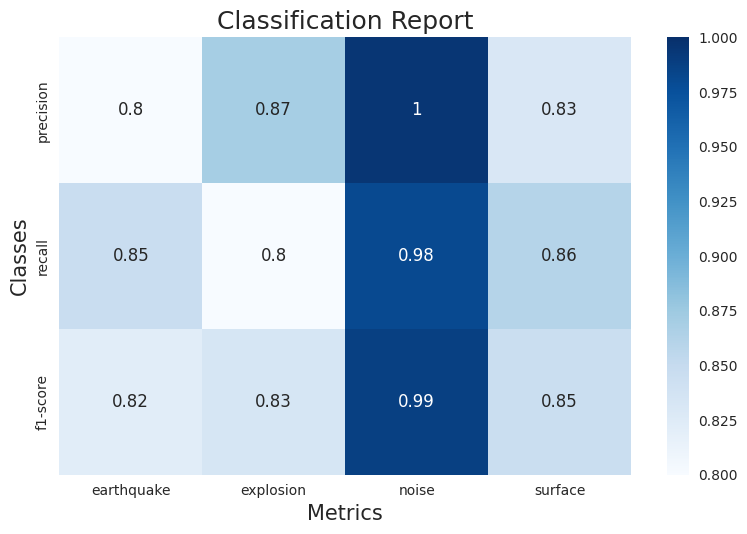

In [18]:
model_quakexnet_1d.eval()
_,_ = plot_confusion_matrix_and_cr(model_quakexnet_1d, test_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## QuakeXNet 2D

In [22]:
model_quakexnet_2d = QuakeXNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_2d, val_loss_time_mycnn_2d, val_accuracy_time_mycnn_2d,test_loss_mycnn_2d,test_accuracy_mycnn_2d) = train_model(model_quakexnet_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:06<00:33,  1.48it/s]

[Epoch 10] loss: 0.663 - accuracy: 78.385


 33%|███▎      | 20/60 [00:13<00:26,  1.51it/s]

[Epoch 20] loss: 0.550 - accuracy: 82.422


 50%|█████     | 30/60 [00:19<00:19,  1.56it/s]

[Epoch 30] loss: 0.480 - accuracy: 83.984


 67%|██████▋   | 40/60 [00:27<00:13,  1.44it/s]

[Epoch 40] loss: 0.449 - accuracy: 84.570


 83%|████████▎ | 50/60 [00:33<00:06,  1.47it/s]

[Epoch 50] loss: 0.419 - accuracy: 85.677


100%|██████████| 60/60 [00:40<00:00,  1.48it/s]

[Epoch 60] loss: 0.385 - accuracy: 86.458
test loss: 0.377 and accuracy: 87.500



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

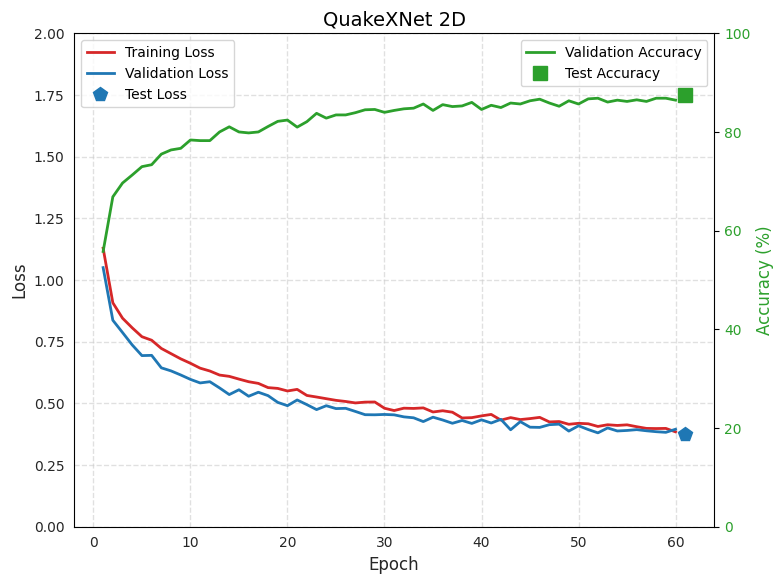

In [24]:
plot_model_training(loss_time_mycnn_2d, val_loss_time_mycnn_2d, val_accuracy_time_mycnn_2d, test_loss_mycnn_2d, test_accuracy_mycnn_2d, title = 'QuakeXNet 2D')

test loss: 0.378 and accuracy: 87.109


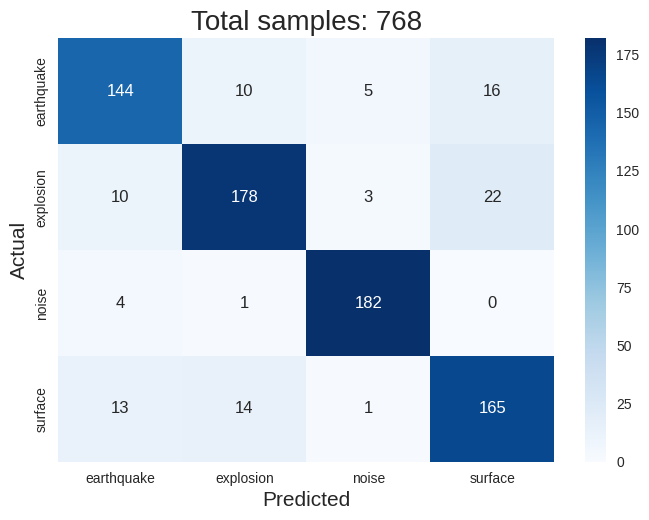

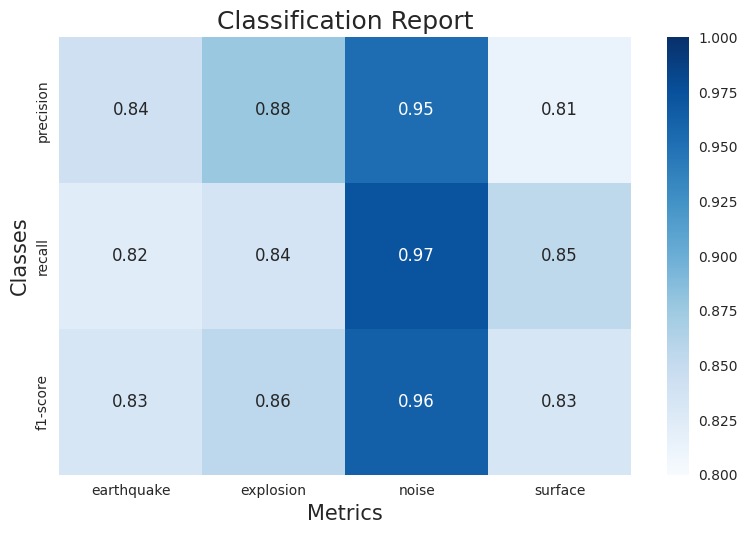

In [25]:
model_quakexnet_2d.eval()
_,_ = plot_confusion_matrix_and_cr(model_quakexnet_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## QuakeXNet 1D on 2D

In [26]:
model_mycnn_1d_on_2d = MyCNN_1d_on_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_mycnn_1d_on_2d, val_loss_time_mycnn_1d_on_2d, val_accuracy_time_mycnn_1d_on_2d,test_loss_mycnn_1d_on_2d,test_accuracy_mycnn_1d_on_2d) = train_model(model_mycnn_1d_on_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30,  model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:06<00:33,  1.51it/s]

[Epoch 10] loss: 0.531 - accuracy: 78.841


 33%|███▎      | 20/60 [00:13<00:26,  1.53it/s]

[Epoch 20] loss: 0.403 - accuracy: 81.641


 50%|█████     | 30/60 [00:19<00:19,  1.53it/s]

[Epoch 30] loss: 0.336 - accuracy: 82.943


 67%|██████▋   | 40/60 [00:26<00:13,  1.52it/s]

[Epoch 40] loss: 0.273 - accuracy: 86.263


 83%|████████▎ | 50/60 [00:32<00:06,  1.53it/s]

[Epoch 50] loss: 0.223 - accuracy: 86.198


100%|██████████| 60/60 [00:39<00:00,  1.52it/s]

[Epoch 60] loss: 0.195 - accuracy: 84.831
test loss: 0.382 and accuracy: 88.281



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

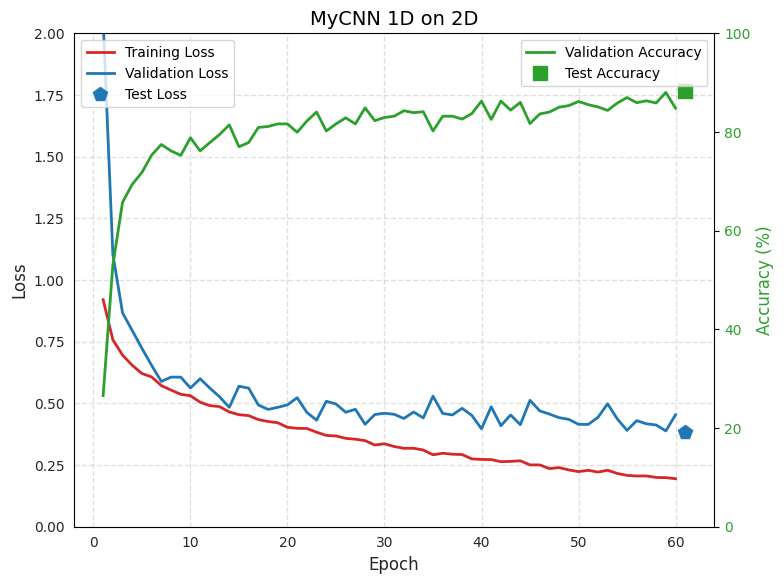

In [27]:
plot_model_training(loss_time_mycnn_1d_on_2d, val_loss_time_mycnn_1d_on_2d, val_accuracy_time_mycnn_1d_on_2d, test_loss_mycnn_1d_on_2d, test_accuracy_mycnn_1d_on_2d, title = 'MyCNN 1D on 2D')

test loss: 0.389 and accuracy: 87.891


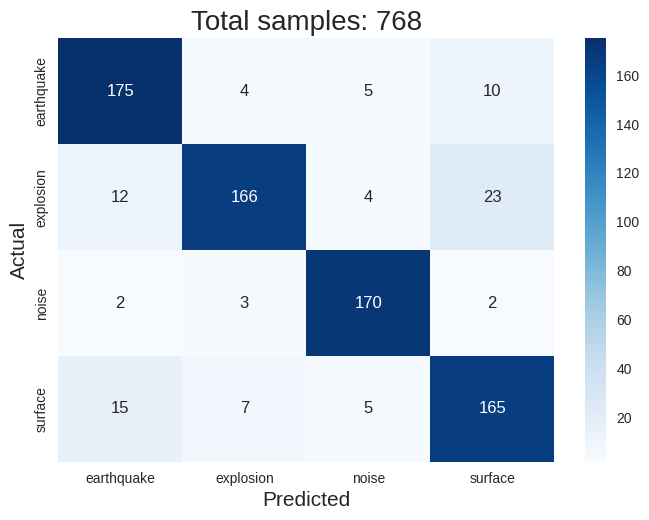

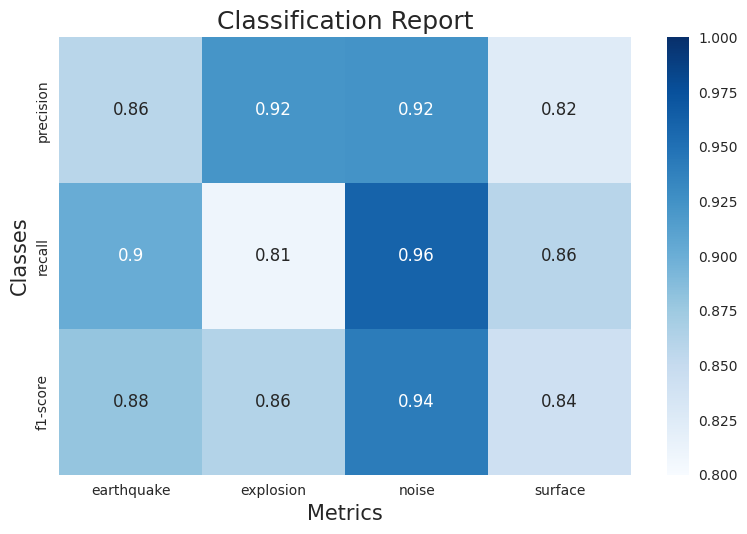

In [28]:
model_mycnn_1d_on_2d.eval()
_,_ = plot_confusion_matrix_and_cr(model_mycnn_1d_on_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)

## BasicResNet 1D

In [19]:
model_basicresnet_1d = BasicResNet_1d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_myrescnn_1d, val_loss_time_myrescnn_1d, val_accuracy_time_myrescnn_1d,test_loss_myrescnn_1d,test_accuracy_myrescnn_1d) = train_model(model_basicresnet_1d,
    train_loader_1d,  val_loader_1d, test_loader_1d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:11<00:54,  1.10s/it]

[Epoch 10] loss: 0.581 - accuracy: 60.417


 33%|███▎      | 20/60 [00:22<00:44,  1.11s/it]

[Epoch 20] loss: 0.490 - accuracy: 58.529


 50%|█████     | 30/60 [00:33<00:32,  1.09s/it]

[Epoch 30] loss: 0.454 - accuracy: 56.901


 67%|██████▋   | 40/60 [00:44<00:21,  1.09s/it]

[Epoch 40] loss: 0.422 - accuracy: 56.120


 67%|██████▋   | 40/60 [00:45<00:22,  1.13s/it]

test loss: 0.735 and accuracy: 72.786



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

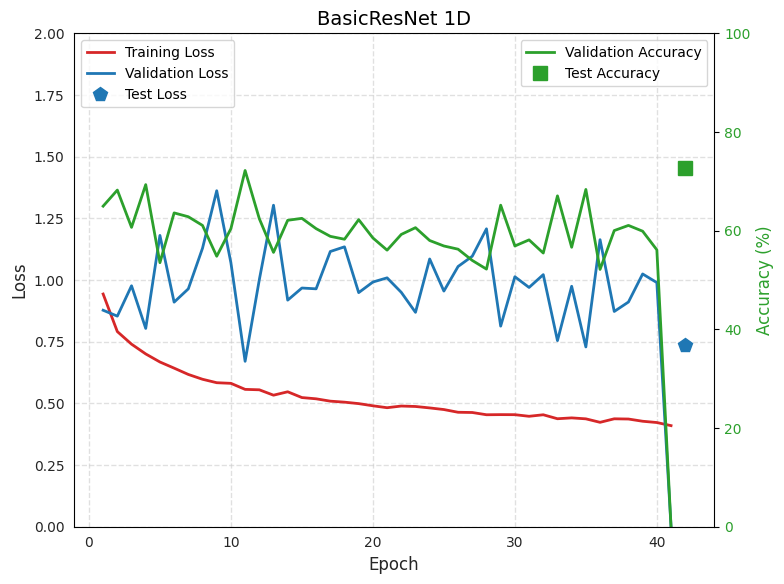

In [20]:
plot_model_training(loss_time_myrescnn_1d, val_loss_time_myrescnn_1d, val_accuracy_time_myrescnn_1d, test_loss_myrescnn_1d, test_accuracy_myrescnn_1d, title = 'BasicResNet 1D')

test loss: 0.715 and accuracy: 73.568


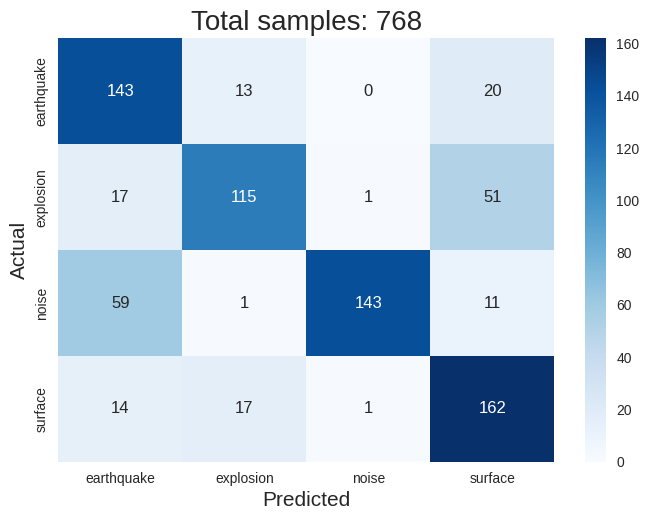

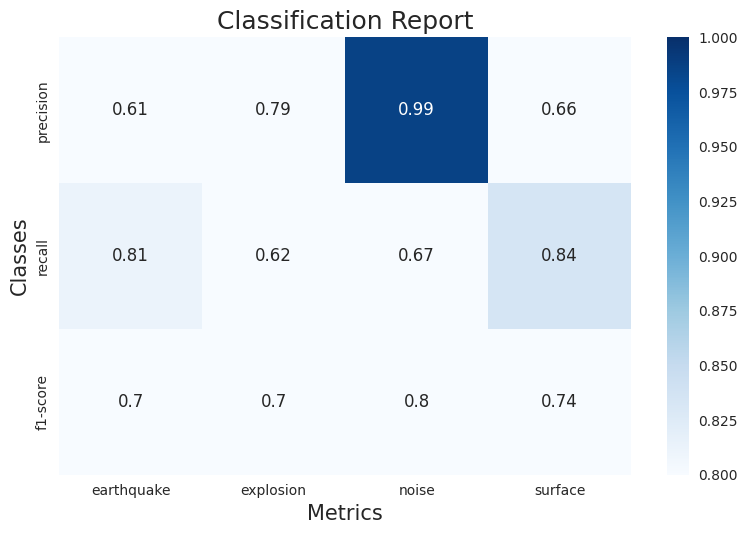

In [21]:
model_basicresnet_1d.eval()
_,_ = plot_confusion_matrix_and_cr(model_basicresnet_1d, test_loader_1d, show_plot = True, criterion = criterion, batch_size = batch_size)

## BasicResNet 2D

In [29]:
model_basicresnet_2d = BasicResNet_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available
(loss_time_myrescnn_2d, val_loss_time_myrescnn_2d, val_accuracy_time_myrescnn_2d,test_loss_myrescnn_2d,test_accuracy_myrescnn_2d) = train_model(model_basicresnet_2d,
    train_loader_2d,  val_loader_2d, test_loader_2d,n_epochs=n_epochs,learning_rate=learning_rate,
    criterion=criterion,augmentation= False, patience = 30, model_path = 'tested_models/best_model_')

 17%|█▋        | 10/60 [00:07<00:33,  1.47it/s]

[Epoch 10] loss: 0.318 - accuracy: 84.180


 33%|███▎      | 20/60 [00:13<00:26,  1.49it/s]

[Epoch 20] loss: 0.196 - accuracy: 85.221


 50%|█████     | 30/60 [00:20<00:18,  1.58it/s]

[Epoch 30] loss: 0.115 - accuracy: 86.393


 67%|██████▋   | 40/60 [00:26<00:13,  1.44it/s]

[Epoch 40] loss: 0.084 - accuracy: 86.068


 83%|████████▎ | 50/60 [00:33<00:06,  1.51it/s]

[Epoch 50] loss: 0.058 - accuracy: 86.068


100%|██████████| 60/60 [00:40<00:00,  1.50it/s]

[Epoch 60] loss: 0.044 - accuracy: 89.779
test loss: 0.372 and accuracy: 89.062



/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts/helper_functions.py:470: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(m

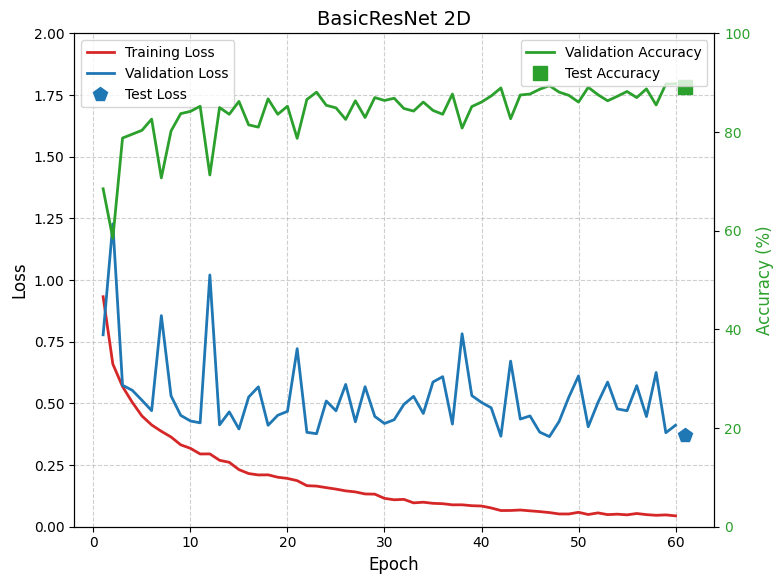

In [31]:
plot_model_training(loss_time_myrescnn_2d, val_loss_time_myrescnn_2d, val_accuracy_time_myrescnn_2d, test_loss_myrescnn_2d, test_accuracy_myrescnn_2d, title = 'BasicResNet 2D')

test loss: 0.363 and accuracy: 89.193


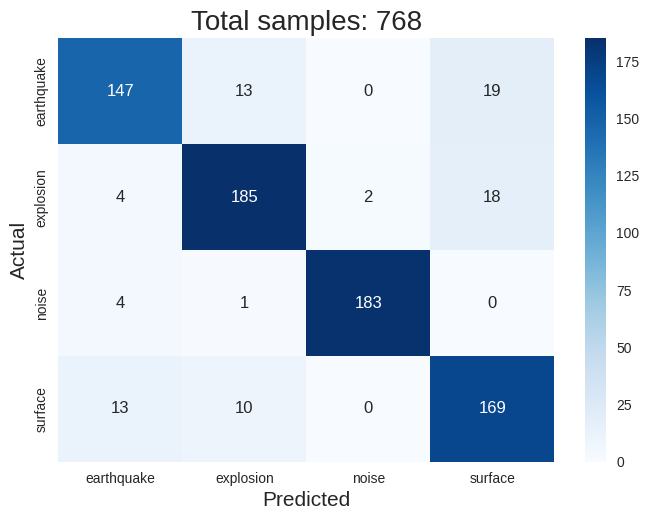

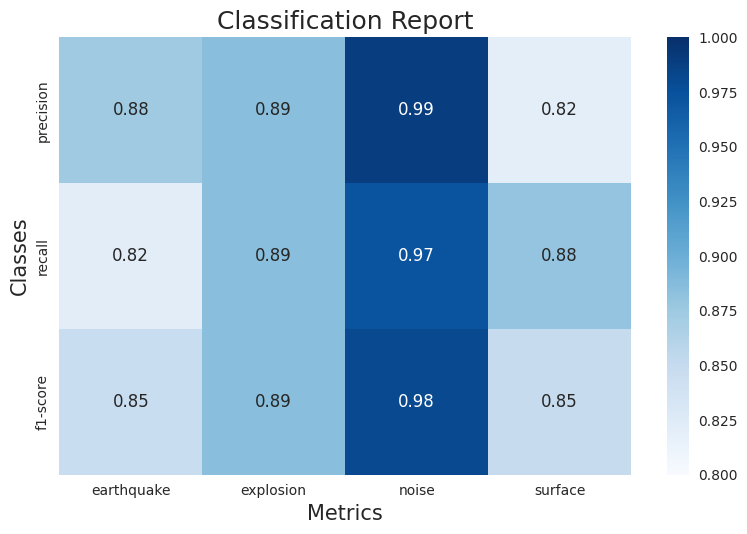

In [34]:
model_basicresnet_2d.eval()
_,_  = plot_confusion_matrix_and_cr(model_basicresnet_2d, test_loader_2d, show_plot = True, criterion = criterion, batch_size = batch_size)